In [1]:
# prune these

# for grabbing data from APIs
import urllib, json
import requests

# for working with the data
import pandas as pd
import numpy as np
import datetime as dt
from pandasgui import show

# for visualization 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# for geodata and GIS prep
import geopandas as gpd
from geopandas import GeoDataFrame

# for mapping
import folium
from shapely.geometry import Point, Polygon
from keplergl import KeplerGl

In [2]:
%%time
# Get the Neighbourhood Profiles data
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "6e19a90f-971c-46b3-852c-0c48c436d1fc"}
package = requests.get(url, params = params).json()

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 3000 }
        data = requests.get(url, params = p).json()
        hood_df = pd.DataFrame(data["result"]["records"])
        break

CPU times: user 323 ms, sys: 116 ms, total: 439 ms
Wall time: 7.87 s


In [3]:
%%time
# Get the COVID-19 Cases in Toronto data
# https://open.toronto.ca/dataset/covid-19-cases-in-toronto/
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "64b54586-6180-4485-83eb-81e8fae3b8fe"}
package = requests.get(url, params = params).json()
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 50000 }
        data = requests.get(url, params = p).json()
        cases_df = pd.DataFrame(data["result"]["records"])
        break

CPU times: user 490 ms, sys: 55.7 ms, total: 545 ms
Wall time: 11.5 s


In [4]:
# get info about the two datasets
# hood_df.info()
# cases_df.info()

In [5]:
# get rid of all the commas
hood_df = hood_df.replace(',','', regex=True)
hood_df.head(5)

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   

                      Data Source               Characteristic  \
0                 City of Toronto         Neighbourhood Number   
1                 City of Toronto         TSNS2020 Designation   
2  Census Profile 98-316-X2016001              Population 2016   
3  Census Profile 98-316-X2016001              Population 2011   
4  Census Profile 98-316-X2016001  Population Change 2011-2016   

  City of Toronto Agincourt North Agincourt South-Malvern West  \
0             n/a             129                          128   
1             n/a  No Designation               No Designation   
2         2731571           29113                        23757   
3         2615060           30279                        21988   
4           4.50%          -3.90%                        8.00%   

        Alderwood           Annex  ... Willowdale West  \
0              20              95  ...              37   
1  No Designation  No Designation  ...  No Designation   
2           12054           30526  ...           16936   
3           11904           29177  ...           15004   
4           1.30%           4.60%  ...          12.90%   

  Willowridge-Martingrove-Richview Woburn Woodbine Corridor Woodbine-Lumsden  \
0                                7    137                64               60   
1                   No Designation    NIA    No Designation   No Designation   
2                            22156  53485             12541             7865   
3                            21343  53350             11703             7826   
4                            3.80%  0.30%             7.20%            0.50%   

         Wychwood  Yonge-Eglinton  Yonge-St.Clair York University Heights  \
0              94             100              97                      27   
1  No Designation  No Designation  No Designation                     NIA   
2           14349           11817           12528                   27593   
3           13986           10578           11652                   27713   
4           2.60%          11.70%           7.50%                  -0.40%   

       Yorkdale-Glen Park  
0                      31  
1  Emerging Neighbourhood  
2                   14804  
3                   14687  
4                   0.80%  

[5 rows x 146 columns]

In [6]:
# probably not using everything all at once, so separate the different categories (e.g. income, language) into their own DFs

# what are all the different categories and classifications?
hood_df.Category.unique()
cases_df.Classification.unique()

array(['CONFIRMED', 'PROBABLE'], dtype=object)

In [7]:
cases_df = cases_df.replace(',','', regex=True)
cases_df.head(2)

_id  Assigned_ID Outbreak Associated       Age Group Neighbourhood Name  \
0  377846            1            Sporadic  50 to 59 Years    Willowdale East   
1  377847            2            Sporadic  50 to 59 Years    Willowdale East   

   FSA Source of Infection Classification Episode Date Reported Date  \
0  M2N              Travel      CONFIRMED   2020-01-22    2020-01-23   
1  M2N              Travel      CONFIRMED   2020-01-21    2020-01-23   

  Client Gender   Outcome Currently Hospitalized Currently in ICU  \
0        FEMALE  RESOLVED                     No               No   
1          MALE  RESOLVED                     No               No   

  Currently Intubated Ever Hospitalized Ever in ICU Ever Intubated  
0                  No                No          No             No  
1                  No               Yes          No             No

In [8]:
# find record of one of the neighbourhoods with misspelled name
# cases_df[cases_df['Neighbourhood Name'].str.contains("Pellam")]

# fix name discrepancies for danforth east york, briar hill-belgravia, and weston-pelham park
# Pelham Park
cases_df['Neighbourhood Name'] = cases_df['Neighbourhood Name'].replace('Weston-Pellam Park', 'Weston-Pelham Park') 
# Danforth East York
cases_df['Neighbourhood Name'] = cases_df['Neighbourhood Name'].replace('Danforth-East York', 'Danforth East York') 
# Brial Hill-Belgravia
cases_df['Neighbourhood Name'] = cases_df['Neighbourhood Name'].replace('Briar Hill - Belgravia', 'Briar Hill-Belgravia') 

In [9]:
# cases_df['count'] = cases_df.groupby('Neighbourhood Name')['Neighbourhood Name'].transform('count')
# cases_df.head()

# if we want to get data without filtering based on classification
# neighbourhood_count = cases_df.groupby(['Neighbourhood Name']).agg(['count'])

# if we want to get counts of confirmed cases only
# need to email city to find out what they're using in the excel spreadsheet they're using on tableau
counts = cases_df.groupby('Neighbourhood Name')['Classification'].apply(lambda x: (x=='CONFIRMED').sum()).reset_index(name='count')

In [10]:
counts.head()

Neighbourhood Name  count
0               Agincourt North    225
1  Agincourt South-Malvern West    147
2                     Alderwood    104
3                         Annex    241
4             Banbury-Don Mills    126

In [11]:
row_counts = counts.pivot_table(columns='Neighbourhood Name')

In [12]:
row_counts.insert(0, '_id', 1)
row_counts.insert(1, 'Category', 1)
row_counts.insert(2, 'Topic', 1)
row_counts.insert(3, 'Data Source', 1)
row_counts.insert(4, 'Characteristic', 1)
row_counts.insert(5, 'City of Toronto', 1)

In [13]:
row_counts.head(1)

Neighbourhood Name  _id  Category  Topic  Data Source  Characteristic  \
count                 1         1      1            1               1   

Neighbourhood Name  City of Toronto  Agincourt North  \
count                             1              225   

Neighbourhood Name  Agincourt South-Malvern West  Alderwood  Annex  ...  \
count                                        147        104    241  ...   

Neighbourhood Name  Willowdale West  Willowridge-Martingrove-Richview  Woburn  \
count                            96                               254     757   

Neighbourhood Name  Woodbine Corridor  Woodbine-Lumsden  Wychwood  \
count                              43                40       127   

Neighbourhood Name  Yonge-Eglinton  Yonge-St.Clair  York University Heights  \
count                           43              51                      733   

Neighbourhood Name  Yorkdale-Glen Park  
count                              352  

[1 rows x 147 columns]

In [14]:
row_counts.reset_index(None)
row_counts = row_counts.rename_axis(None)

In [15]:
row_counts.loc[hood_df.index[2]] = hood_df.iloc[2]

In [16]:
row_counts.head(3)

Neighbourhood Name  _id    Category                     Topic  \
count                 1           1                         1   
2                     3  Population  Population and dwellings   

Neighbourhood Name                     Data Source   Characteristic  \
count                                            1                1   
2                   Census Profile 98-316-X2016001  Population 2016   

Neighbourhood Name City of Toronto Agincourt North  \
count                            1             225   
2                          2731571           29113   

Neighbourhood Name Agincourt South-Malvern West Alderwood  Annex  ...  \
count                                       147       104    241  ...   
2                                         23757     12054  30526  ...   

Neighbourhood Name Willowdale West Willowridge-Martingrove-Richview Woburn  \
count                           96                              254    757   
2                            16936                            22156  53485   

Neighbourhood Name Woodbine Corridor Woodbine-Lumsden Wychwood Yonge-Eglinton  \
count                             43               40      127             43   
2                              12541             7865    14349          11817   

Neighbourhood Name Yonge-St.Clair York University Heights Yorkdale-Glen Park  
count                          51                     733                352  
2                           12528                   27593              14804  

[2 rows x 147 columns]

In [17]:
# row_counts.set_value(1, '_id', 0)
row_counts.loc[2,'_id'] = 1
row_counts.loc[2,'Category'] = 1
row_counts.loc[2,'Topic'] = 1
row_counts.loc[2,'Data Source'] = 1
row_counts.loc[2,'Characteristic'] = 1
row_counts.loc[2,'City of Toronto'] = 1

In [18]:
row_counts.head(2)

Neighbourhood Name  _id Category Topic Data Source Characteristic  \
count                 1        1     1           1              1   
2                     1        1     1           1              1   

Neighbourhood Name City of Toronto Agincourt North  \
count                            1             225   
2                                1           29113   

Neighbourhood Name Agincourt South-Malvern West Alderwood  Annex  ...  \
count                                       147       104    241  ...   
2                                         23757     12054  30526  ...   

Neighbourhood Name Willowdale West Willowridge-Martingrove-Richview Woburn  \
count                           96                              254    757   
2                            16936                            22156  53485   

Neighbourhood Name Woodbine Corridor Woodbine-Lumsden Wychwood Yonge-Eglinton  \
count                             43               40      127             43   
2                              12541             7865    14349          11817   

Neighbourhood Name Yonge-St.Clair York University Heights Yorkdale-Glen Park  
count                          51                     733                352  
2                           12528                   27593              14804  

[2 rows x 147 columns]

In [19]:
row_counts.reset_index(drop=True, inplace=True)
row_counts.head()

Neighbourhood Name  _id Category Topic Data Source Characteristic  \
0                     1        1     1           1              1   
1                     1        1     1           1              1   

Neighbourhood Name City of Toronto Agincourt North  \
0                                1             225   
1                                1           29113   

Neighbourhood Name Agincourt South-Malvern West Alderwood  Annex  ...  \
0                                           147       104    241  ...   
1                                         23757     12054  30526  ...   

Neighbourhood Name Willowdale West Willowridge-Martingrove-Richview Woburn  \
0                               96                              254    757   
1                            16936                            22156  53485   

Neighbourhood Name Woodbine Corridor Woodbine-Lumsden Wychwood Yonge-Eglinton  \
0                                 43               40      127             43   
1                              12541             7865    14349          11817   

Neighbourhood Name Yonge-St.Clair York University Heights Yorkdale-Glen Park  
0                              51                     733                352  
1                           12528                   27593              14804  

[2 rows x 147 columns]

In [20]:
#row_counts = row_counts.astype('int64')
cols = row_counts.columns
row_counts[cols] = row_counts[cols].apply(pd.to_numeric, errors='coerce')
# row_counts = pd.to_numeric(row_counts, errors='coerce')

In [21]:
# # add a new row for rate per 100k
# 100000/row 2 value * row 0 value
row_counts.loc[-1] = 100000 / row_counts.iloc[1] * row_counts.iloc[0]  # adding a row
row_counts.index = row_counts.index + 1  # shifting index
row_counts.sort_index(inplace=True) 

In [22]:
row_counts.head()

Neighbourhood Name       _id  Category     Topic  Data Source  Characteristic  \
0                   100000.0  100000.0  100000.0     100000.0        100000.0   
1                        1.0       1.0       1.0          1.0             1.0   
2                        1.0       1.0       1.0          1.0             1.0   

Neighbourhood Name  City of Toronto  Agincourt North  \
0                          100000.0       772.850617   
1                               1.0       225.000000   
2                               1.0     29113.000000   

Neighbourhood Name  Agincourt South-Malvern West     Alderwood         Annex  \
0                                     618.764996    862.784138    789.490926   
1                                     147.000000    104.000000    241.000000   
2                                   23757.000000  12054.000000  30526.000000   

Neighbourhood Name  ...  Willowdale West  Willowridge-Martingrove-Richview  \
0                   ...       566.839868                       1146.416321   
1                   ...        96.000000                        254.000000   
2                   ...     16936.000000                      22156.000000   

Neighbourhood Name        Woburn  Woodbine Corridor  Woodbine-Lumsden  \
0                    1415.350098         342.875369        508.582327   
1                     757.000000          43.000000         40.000000   
2                   53485.000000       12541.000000       7865.000000   

Neighbourhood Name    Wychwood  Yonge-Eglinton  Yonge-St.Clair  \
0                     885.0791      363.882542      407.088123   
1                     127.0000       43.000000       51.000000   
2                   14349.0000    11817.000000    12528.000000   

Neighbourhood Name  York University Heights  Yorkdale-Glen Park  
0                               2656.470844         2377.735747  
1                                733.000000          352.000000  
2                              27593.000000        14804.000000  

[3 rows x 147 columns]

In [23]:
row_counts = row_counts.drop([2])

In [24]:
# combine with the neighbourhood data
frames = [row_counts, hood_df]
hood_df = pd.concat(frames)

In [25]:
# fix this so it doesn't create a new column
# hood_df.reset_index(None)
# hood_df.iloc[0].astype(int)
hood_df.head()

_id                   Category                      Topic  \
0  100000.0                     100000                     100000   
1       1.0                          1                          1   
0       1.0  Neighbourhood Information  Neighbourhood Information   
1       2.0  Neighbourhood Information  Neighbourhood Information   
2       3.0                 Population   Population and dwellings   

                      Data Source        Characteristic City of Toronto  \
0                          100000                100000          100000   
1                               1                     1               1   
0                 City of Toronto  Neighbourhood Number             n/a   
1                 City of Toronto  TSNS2020 Designation             n/a   
2  Census Profile 98-316-X2016001       Population 2016         2731571   

  Agincourt North Agincourt South-Malvern West       Alderwood  \
0         772.851                      618.765         862.784   
1             225                          147             104   
0             129                          128              20   
1  No Designation               No Designation  No Designation   
2           29113                        23757           12054   

            Annex  ... Willowdale West Willowridge-Martingrove-Richview  \
0         789.491  ...          566.84                          1146.42   
1             241  ...              96                              254   
0              95  ...              37                                7   
1  No Designation  ...  No Designation                   No Designation   
2           30526  ...           16936                            22156   

    Woburn Woodbine Corridor Woodbine-Lumsden        Wychwood  Yonge-Eglinton  \
0  1415.35           342.875          508.582         885.079         363.883   
1      757                43               40             127              43   
0      137                64               60              94             100   
1      NIA    No Designation   No Designation  No Designation  No Designation   
2    53485             12541             7865           14349           11817   

   Yonge-St.Clair York University Heights      Yorkdale-Glen Park  
0         407.088                 2656.47                 2377.74  
1              51                     733                     352  
0              97                      27                      31  
1  No Designation                     NIA  Emerging Neighbourhood  
2           12528                   27593                   14804  

[5 rows x 147 columns]

In [26]:
hood_df = hood_df.drop(['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'], axis = 1);

In [27]:
#hood_df['Characteristic'].astype(object)
# hood_df['Characteristic'].replace({100000: 'Rate', 1: 'Cases'})

# rename a different way
hood_df.Characteristic[hood_df.Characteristic == 100000] = "Rate"
hood_df.Characteristic[hood_df.Characteristic == 1] = "Cases"
hood_df.head()

<ipython-input-27-db818f362ffd>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-db818f362ffd>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Characteristic Agincourt North Agincourt South-Malvern West  \
0                  Rate         772.851                      618.765   
1                 Cases             225                          147   
0  Neighbourhood Number             129                          128   
1  TSNS2020 Designation  No Designation               No Designation   
2       Population 2016           29113                        23757   

        Alderwood           Annex Banbury-Don Mills  Bathurst Manor  \
0         862.784         789.491           454.956          1789.2   
1             104             241               126             284   
0              20              95                42              34   
1  No Designation  No Designation    No Designation  No Designation   
2           12054           30526             27695           15873   

  Bay Street Corridor Bayview Village Bayview Woods-Steeles  ...  \
0             534.946         406.618               1147.94  ...   
1                 138              87                   151  ...   
0                  76              52                    49  ...   
1      No Designation  No Designation        No Designation  ...   
2               25797           21396                 13154  ...   

  Willowdale West Willowridge-Martingrove-Richview   Woburn Woodbine Corridor  \
0          566.84                          1146.42  1415.35           342.875   
1              96                              254      757                43   
0              37                                7      137                64   
1  No Designation                   No Designation      NIA    No Designation   
2           16936                            22156    53485             12541   

  Woodbine-Lumsden        Wychwood  Yonge-Eglinton  Yonge-St.Clair  \
0          508.582         885.079         363.883         407.088   
1               40             127              43              51   
0               60              94             100              97   
1   No Designation  No Designation  No Designation  No Designation   
2             7865           14349           11817           12528   

  York University Heights      Yorkdale-Glen Park  
0                 2656.47                 2377.74  
1                     733                     352  
0                      27                      31  
1                     NIA  Emerging Neighbourhood  
2                   27593                   14804  

[5 rows x 142 columns]

In [28]:
# create a pivot table and use Characteristic column as index
trans = hood_df.set_index('Characteristic').T

In [29]:
trans.head(5)

Characteristic                   Rate Cases Neighbourhood Number  \
Agincourt North               772.851   225                  129   
Agincourt South-Malvern West  618.765   147                  128   
Alderwood                     862.784   104                   20   
Annex                         789.491   241                   95   
Banbury-Don Mills             454.956   126                   42   

Characteristic               TSNS2020 Designation Population 2016  \
Agincourt North                    No Designation           29113   
Agincourt South-Malvern West       No Designation           23757   
Alderwood                          No Designation           12054   
Annex                              No Designation           30526   
Banbury-Don Mills                  No Designation           27695   

Characteristic               Population 2011 Population Change 2011-2016  \
Agincourt North                        30279                      -3.90%   
Agincourt South-Malvern West           21988                       8.00%   
Alderwood                              11904                       1.30%   
Annex                                  29177                       4.60%   
Banbury-Don Mills                      26918                       2.90%   

Characteristic               Total private dwellings  \
Agincourt North                                 9371   
Agincourt South-Malvern West                    8535   
Alderwood                                       4732   
Annex                                          18109   
Banbury-Don Mills                              12473   

Characteristic               Private dwellings occupied by usual residents  \
Agincourt North                                                       9120   
Agincourt South-Malvern West                                          8136   
Alderwood                                                             4616   
Annex                                                                15934   
Banbury-Don Mills                                                    12124   

Characteristic               Population density per square kilometre  ...  \
Agincourt North                                                 3929  ...   
Agincourt South-Malvern West                                    3034  ...   
Alderwood                                                       2435  ...   
Annex                                                          10863  ...   
Banbury-Don Mills                                               2775  ...   

Characteristic                       Intraprovincial migrants  \
Agincourt North                                           275   
Agincourt South-Malvern West                              320   
Alderwood                                                 220   
Annex                                                     900   
Banbury-Don Mills                                         345   

Characteristic                       Interprovincial migrants  \
Agincourt North                                            75   
Agincourt South-Malvern West                               90   
Alderwood                                                  40   
Annex                                                     385   
Banbury-Don Mills                                          75   

Characteristic                     External migrants  \
Agincourt North                                  605   
Agincourt South-Malvern West                     490   
Alderwood                                         70   
Annex                                            835   
Banbury-Don Mills                                380   

Characteristic               Total - Mobility status 5 years ago - 25% sample data  \
Agincourt North                                                           27490      
Agincourt South-Malvern West                                              22325      
Alderwood                                                                

In [30]:
trans.reset_index(inplace = True)
trans.head()

Characteristic                         index     Rate Cases  \
0                            Agincourt North  772.851   225   
1               Agincourt South-Malvern West  618.765   147   
2                                  Alderwood  862.784   104   
3                                      Annex  789.491   241   
4                          Banbury-Don Mills  454.956   126   

Characteristic Neighbourhood Number TSNS2020 Designation Population 2016  \
0                               129       No Designation           29113   
1                               128       No Designation           23757   
2                                20       No Designation           12054   
3                                95       No Designation           30526   
4                                42       No Designation           27695   

Characteristic Population 2011 Population Change 2011-2016  \
0                        30279                      -3.90%   
1                        21988                       8.00%   
2                        11904                       1.30%   
3                        29177                       4.60%   
4                        26918                       2.90%   

Characteristic Total private dwellings  \
0                                 9371   
1                                 8535   
2                                 4732   
3                                18109   
4                                12473   

Characteristic Private dwellings occupied by usual residents  ...  \
0                                                       9120  ...   
1                                                       8136  ...   
2                                                       4616  ...   
3                                                      15934  ...   
4                                                      12124  ...   

Characteristic         Intraprovincial migrants  \
0                                           275   
1                                           320   
2                                           220   
3                                           900   
4                                           345   

Characteristic         Interprovincial migrants       External migrants  \
0                                            75                     605   
1                                            90                     490   
2                                            40                      70   
3                                           385                     835   
4                                            75                     380   

Characteristic Total - Mobility status 5 years ago - 25% sample data  \
0                                                           27490      
1                                                           22325      
2                                                           11370      
3                                                           27715      
4                                                           25925      

Characteristic   Non-movers   Movers     Non-migrants     Migrants  \
0                     18865     8610             5445         3170   
1                     13565     8775             5610         3145   
2                      8235     3130             2200          925   
3                     12980    14735             8340         6390   
4                     16300     9625             6480         3140   

Characteristic         Interprovincial migrants       External migrants  
0                                           135                    2280  
1                                           220                    2170  
2                                            70                     245  
3                                          1310                    2460  
4                                           220                    1735  

[5 rows x 2386 columns]

In [31]:
# make sure the values in each column you want to use for visualization are numeric
trans['Population 2016'] = pd.to_numeric(trans['Population 2016'], errors='coerce')
trans['Total private dwellings'] = pd.to_numeric(trans['Total private dwellings'], errors='coerce')
trans['Population density per square kilometre'] = pd.to_numeric(trans['Population density per square kilometre'], errors='coerce')

In [32]:
# fill any NaN values
trans['Population 2016'] = trans['Population 2016'].fillna(0)
trans['Total private dwellings'] = trans['Total private dwellings'].fillna(0)
trans['Population density per square kilometre'] = trans['Population density per square kilometre'].fillna(0)

In [33]:
# set the value types before creating visualization
trans['Population 2016'] = trans['Population 2016'].astype('int64')
#trans = trans[trans['Population 2016'].pd.to_numeric(df['x'], errors='coerce')
trans['Total private dwellings'] = trans['Total private dwellings'].astype('int64')
trans['Population density per square kilometre'] = trans['Population density per square kilometre'].astype('int64')

In [34]:
trans = trans.rename(columns={"index": "Neighbourhood"})
trans.head()

Characteristic                 Neighbourhood     Rate Cases  \
0                            Agincourt North  772.851   225   
1               Agincourt South-Malvern West  618.765   147   
2                                  Alderwood  862.784   104   
3                                      Annex  789.491   241   
4                          Banbury-Don Mills  454.956   126   

Characteristic Neighbourhood Number TSNS2020 Designation  Population 2016  \
0                               129       No Designation            29113   
1                               128       No Designation            23757   
2                                20       No Designation            12054   
3                                95       No Designation            30526   
4                                42       No Designation            27695   

Characteristic Population 2011 Population Change 2011-2016  \
0                        30279                      -3.90%   
1                        21988                       8.00%   
2                        11904                       1.30%   
3                        29177                       4.60%   
4                        26918                       2.90%   

Characteristic  Total private dwellings  \
0                                  9371   
1                                  8535   
2                                  4732   
3                                 18109   
4                                 12473   

Characteristic Private dwellings occupied by usual residents  ...  \
0                                                       9120  ...   
1                                                       8136  ...   
2                                                       4616  ...   
3                                                      15934  ...   
4                                                      12124  ...   

Characteristic          Intraprovincial migrants  \
0                                            275   
1                                            320   
2                                            220   
3                                            900   
4                                            345   

Characteristic         Interprovincial migrants       External migrants  \
0                                            75                     605   
1                                            90                     490   
2                                            40                      70   
3                                           385                     835   
4                                            75                     380   

Characteristic Total - Mobility status 5 years ago - 25% sample data  \
0                                                           27490      
1                                                           22325      
2                                                           11370      
3                                                           27715      
4                                                           25925      

Characteristic   Non-movers   Movers     Non-migrants     Migrants  \
0                     18865     8610             5445         3170   
1                     13565     8775             5610         3145   
2                      8235     3130             2200          925   
3                     12980    14735             8340         6390   
4                     16300     9625             6480         3140   

Characteristic         Interprovincial migrants       External migrants  
0                                           135                    2280  
1                                           220                    2170  
2                                            70                     245  
3                                          1310                    2460  
4                                           220                    1735  

[5 rows x 2386 columns]

In [35]:
# create a column for percentage of visible minorities in neighbourhood
trans['  Total visible minority population'] = pd.to_numeric(trans['  Total visible minority population'], errors='coerce')
#trans['  Total visible minority population'] = trans['  Total visible minority population'].astype('int64')
#trans['  Total visible minority population'] = trans['  Total visible minority population'].fillna(0)
trans['Visible Minority Percentage'] = trans['  Total visible minority population'] / trans['Population 2016'] * 100

In [36]:
# create a column for non-visible minorities
trans['  Not a visible minority'] = pd.to_numeric(trans['  Not a visible minority'], errors='coerce')
#trans['  Total visible minority population'] = trans['  Total visible minority population'].astype('int64')
#trans['  Total visible minority population'] = trans['  Total visible minority population'].fillna(0)
trans['Not a Visible Minority Percentage'] = trans['  Not a visible minority'] / trans['Population 2016'] * 100

In [37]:
trans.head()

Characteristic                 Neighbourhood     Rate Cases  \
0                            Agincourt North  772.851   225   
1               Agincourt South-Malvern West  618.765   147   
2                                  Alderwood  862.784   104   
3                                      Annex  789.491   241   
4                          Banbury-Don Mills  454.956   126   

Characteristic Neighbourhood Number TSNS2020 Designation  Population 2016  \
0                               129       No Designation            29113   
1                               128       No Designation            23757   
2                                20       No Designation            12054   
3                                95       No Designation            30526   
4                                42       No Designation            27695   

Characteristic Population 2011 Population Change 2011-2016  \
0                        30279                      -3.90%   
1                        21988                       8.00%   
2                        11904                       1.30%   
3                        29177                       4.60%   
4                        26918                       2.90%   

Characteristic  Total private dwellings  \
0                                  9371   
1                                  8535   
2                                  4732   
3                                 18109   
4                                 12473   

Characteristic Private dwellings occupied by usual residents  ...  \
0                                                       9120  ...   
1                                                       8136  ...   
2                                                       4616  ...   
3                                                      15934  ...   
4                                                      12124  ...   

Characteristic       External migrants  \
0                                  605   
1                                  490   
2                                   70   
3                                  835   
4                                  380   

Characteristic Total - Mobility status 5 years ago - 25% sample data  \
0                                                           27490      
1                                                           22325      
2                                                           11370      
3                                                           27715      
4                                                           25925      

Characteristic   Non-movers   Movers     Non-migrants     Migrants  \
0                     18865     8610             5445         3170   
1                     13565     8775             5610         3145   
2                      8235     3130             2200          925   
3                     12980    14735             8340         6390   
4                     16300     9625             6480         3140   

Characteristic         Interprovincial migrants       External migrants  \
0                                           135                    2280   
1                                           220                    2170   
2                                            70                     245   
3                                          1310                    2460   
4                                           220                    1735   

Characteristic Visible Minority Percentage Not a Visible Minority Percentage  
0                                90.560918                          8.467008  
1                                84.838153                         13.974828  
2                                20.657043                         79.102373  
3                                23.815764                         70.038656  
4                                45.856653                         51.597761  

[5 rows x 2388 columns]

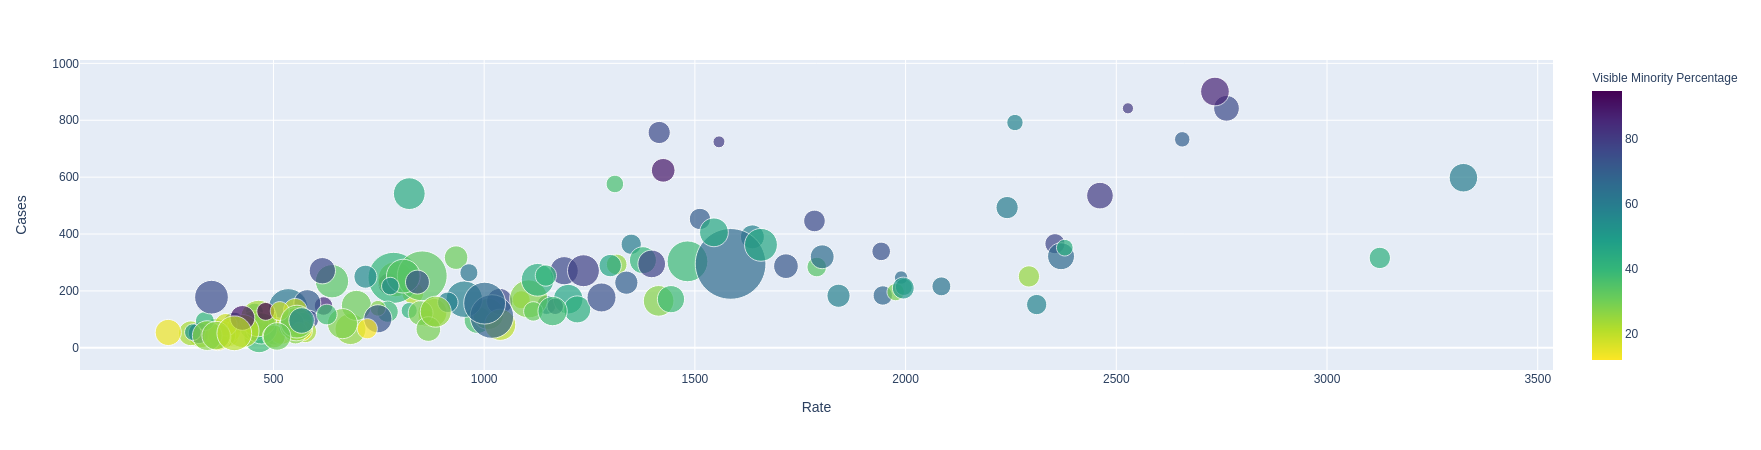

In [38]:
# bubble using plotly express
# plotly's built in colour scales: https://plotly.com/python/builtin-colorscales/
fig = px.scatter(trans, 
                 x="Rate",
                 y="Cases", 
                 size="Population density per square kilometre", 
                 color="Visible Minority Percentage",
                 color_continuous_scale=px.colors.sequential.Viridis_r,
                 hover_name="Neighbourhood", 
                 # log_x=True,
                 size_max=50
                )
#plotly.offline.plot(fig, filename='nightingale_bubble.html')
fig.show()

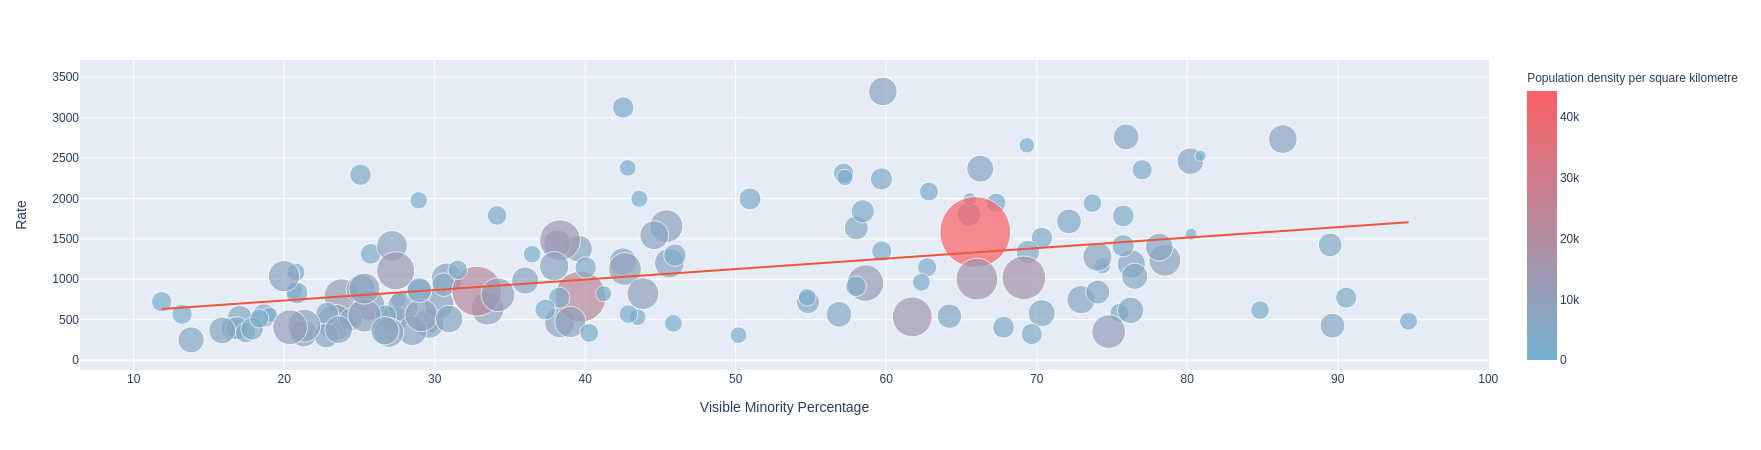

In [39]:
# bubble using plotly express
# see this to set discrete colour scale https://plotly.com/python/discrete-color/
fig = px.scatter(trans, 
                 x="Visible Minority Percentage",
                 y="Rate", 
                 size="Population density per square kilometre", 
                 color="Population density per square kilometre",
                 color_continuous_scale=[[0, '#74b3d3'], [1.0, '#fb6066']],
                 hover_name="Neighbourhood",
                 trendline="ols",
                 # log_x=True,
                 size_max=50
                )
#plotly.offline.plot(fig, filename='nightingale_bubble.html')
fig.show()

# watch what happens when you set x and color to visible minority percentage
# what would happen if we set a condition where we'd only draw from neighbourhoods above a certain population density?

In [40]:
trans.to_csv('data/toronto_neighbourhood_covid.csv')

In [41]:
# don't need this for the time being, but keep since it's a bit more current than the df from the API

# get COVID neighbourhood data from the city https://drive.google.com/file/d/1jzH64LvFQ-UsDibXO0MOtvjbL2CvnV3N/view
# https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/
# need to set up to read from api instead of downloaded file
to_df = pd.read_excel('data/CityofToronto_COVID-19_NeighbourhoodData.xlsx', 1)
to_geo = gpd.read_file("geodata/NEIGHBORHOODS_WGS84.shp")

In [42]:
# get rid of trailing zeroes in ID column
to_df['Neighbourhood ID'] = to_df['Neighbourhood ID'].fillna(0)
to_df['Neighbourhood ID'] = to_df['Neighbourhood ID'].astype('int64')      
# to_df['Neighbourhood ID'] = to_df['Neighbourhood ID'].str.replace('.0', ' ')
to_df.sort_values(by=['Neighbourhood Name'], ascending=True)

Neighbourhood ID            Neighbourhood Name  Rate per 100,000 people  \
128               129               Agincourt North               594.236252   
127               128  Agincourt South-Malvern West               505.114282   
19                 20                     Alderwood               721.752115   
94                 95                         Annex               802.594510   
41                 42             Banbury-Don Mills               328.579166   
..                ...                           ...                      ...   
93                 94                      Wychwood               864.171719   
99                100                Yonge-Eglinton               321.570619   
96                 97                Yonge-St.Clair               407.088123   
26                 27       York University Heights              2395.535099   
30                 31            Yorkdale-Glen Park              2249.392056   

     Case Count  
128         173  
127         120  
19           87  
94          245  
41           91  
..          ...  
93          124  
99           38  
96           51  
26          661  
30          333  

[141 rows x 4 columns]

In [43]:
# change ID to int64
to_geo['AREA_S_CD'] = to_geo['AREA_S_CD'].astype('int64')
# get rid of the bracketed IDs in the name field
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].str.replace(" \\(\\d+\\)", "")
# fix Pelham Park
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('Weston-Pellam Park', 'Weston-Pelham Park') 
# fix Cabbagetown
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('Cabbagetown-South St.James Town', 'Cabbagetown-South St. James Town') 
# fix North St. James
to_geo['AREA_NAME'] = to_geo['AREA_NAME'].replace('North St.James Town', 'North St. James Town')
to_geo.sort_values(by=['AREA_NAME'], ascending=True)

AREA_S_CD                     AREA_NAME  \
79         129               Agincourt North   
80         128  Agincourt South-Malvern West   
86          20                     Alderwood   
56          95                         Annex   
84          42             Banbury-Don Mills   
..         ...                           ...   
137         94                      Wychwood   
128        100                Yonge-Eglinton   
0           97                Yonge-St.Clair   
1           27       York University Heights   
3           31            Yorkdale-Glen Park   

                                              geometry  
79   POLYGON ((-79.24213 43.80247, -79.24319 43.802...  
80   POLYGON ((-79.25498 43.78122, -79.25797 43.780...  
86   POLYGON ((-79.54866 43.59022, -79.54876 43.590...  
56   POLYGON ((-79.39414 43.66872, -79.39588 43.668...  
84   POLYGON ((-79.33055 43.73979, -79.33044 43.739...  
..                                                 ...  
137  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
128  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
0    POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
1    POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
3    POLYGON ((-79.43969 43.70561, -79.44011 43.705...  

[140 rows x 3 columns]

In [44]:
# don't need any of these anymore, but keep for the sake of posterity

# get rid of the bracketed area code in the area name field
# find name of one of the neighbourhoods that doesn't show up because of name discrepancy
# to_df[to_df['Neighbourhood Name'].str.contains("Cabbagetown")]
# should probably just fix the full geojson directly

In [45]:
# add these so they'll show up in tooltips

# add rate from the pandas df to the geopandas df
# to_geo['Rate Per 100,000'] = to_df['Rate per 100,000 people']
# add case count from the pandas df to the geopandas df
# to_geo['Case Count'] = to_df['Case Count']

In [46]:
# change column names
to_geo = to_geo.rename(columns={'AREA_S_CD': "ID", 'AREA_NAME': "Neighbourhood", 'Case Count': "Cases", 'Rate Per 100,000': "Rate"})
to_df = to_df.rename(columns={'Neighbourhood ID': "ID", 'Neighbourhood Name': "Neighbourhood", 'Case Count': "Cases", 'Rate per 100,000 people': "Rate"})

In [47]:
to_df.sort_values(by=['Neighbourhood'], ascending=True)

ID                 Neighbourhood         Rate  Cases
128  129               Agincourt North   594.236252    173
127  128  Agincourt South-Malvern West   505.114282    120
19    20                     Alderwood   721.752115     87
94    95                         Annex   802.594510    245
41    42             Banbury-Don Mills   328.579166     91
..   ...                           ...          ...    ...
93    94                      Wychwood   864.171719    124
99   100                Yonge-Eglinton   321.570619     38
96    97                Yonge-St.Clair   407.088123     51
26    27       York University Heights  2395.535099    661
30    31            Yorkdale-Glen Park  2249.392056    333

[141 rows x 4 columns]

In [48]:
to_geo.sort_values(by=['Neighbourhood'], ascending=True)

ID                 Neighbourhood  \
79   129               Agincourt North   
80   128  Agincourt South-Malvern West   
86    20                     Alderwood   
56    95                         Annex   
84    42             Banbury-Don Mills   
..   ...                           ...   
137   94                      Wychwood   
128  100                Yonge-Eglinton   
0     97                Yonge-St.Clair   
1     27       York University Heights   
3     31            Yorkdale-Glen Park   

                                              geometry  
79   POLYGON ((-79.24213 43.80247, -79.24319 43.802...  
80   POLYGON ((-79.25498 43.78122, -79.25797 43.780...  
86   POLYGON ((-79.54866 43.59022, -79.54876 43.590...  
56   POLYGON ((-79.39414 43.66872, -79.39588 43.668...  
84   POLYGON ((-79.33055 43.73979, -79.33044 43.739...  
..                                                 ...  
137  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
128  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
0    POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
1    POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
3    POLYGON ((-79.43969 43.70561, -79.44011 43.705...  

[140 rows x 3 columns]

In [49]:
# use merge to get the columns from to_df
merged_geo = pd.merge(to_df, to_geo, on=['ID', 'Neighbourhood'])

In [50]:
# need this turn the merged df into a geo df (basically, to get folium to recognize the geometry)
merged_geo = GeoDataFrame(merged_geo)

In [51]:
# not interactive
map_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
# use this if want to load from a geojson file toronto_geo = "./geodata/to_geo.geojson"
folium.Choropleth(
    geo_data=merged_geo, # otherwise, use the geodataframe stored above
    data = to_df,
    columns=['Neighbourhood','Cases'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Case Count by Neighbourhood').add_to(map_toronto)   
    
map_toronto
# demonstrate how the PHU names in the public shapefile don't match

In [52]:
# interactive
map_to = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
# to_geo = "./geodata/to_geo.geojson"
folium.Choropleth(
    geo_data=merged_geo,
    data = to_df,
    columns=['Neighbourhood','Rate'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rate per 100,000 people').add_to(map_to)

folium.GeoJson(
        merged_geo, 
        name='Toronto Neighbourhoods',
        show=True,
        style_function=lambda feature: {
            # 'fillColor': 'YlOrRd',
            'color': 'YlOrRd',
            'weight': .1,
            'dashArray': '5, 5',
            'fillOpacity':0
        },   
        highlight_function=lambda x: {'weight':1, 
                                      'color':'black'
                                      #'fillOpacity':1
                                     },    
        tooltip=folium.features.GeoJsonTooltip(
            fields=['Neighbourhood', 'ID', 'Cases', 'Rate'],
            labels=True,                              
        ),  
).add_to(map_to)
    
map_to

# choropleth colors are not accurate for the rate per 100k in each neighbourhood


In [53]:
# next steps: add 3D, customize tooltips, and make more maps
# maybe also do other regions or the entire country. what boundary-level data is available?
# https://towardsdatascience.com/an-interactive-3d-map-of-police-action-s-that-have-resulted-in-death-b9d7fbf81822
# https://medium.com/vis-gl/introducing-kepler-gl-for-jupyter-f72d41659fbf
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# clean up tooltips https://towardsdatascience.com/using-folium-to-generate-choropleth-map-with-customised-tooltips-12e4cec42af2

In [54]:
# write to file for use in QGIS
merged_geo.to_file('geodata/merged_geo.geojson', driver='GeoJSON')

In [55]:
to_geo = to_geo.to_crs(epsg=4326)

In [56]:
# get centroids if want to use for hexbin 3D in kepler map

# centroid = to_geo['geometry'].to_crs()
# centroidseries = to_geo['geometry'].centroid
to_geo["x"] = to_geo['geometry'].centroid.x
to_geo["y"] = to_geo['geometry'].centroid.y

#def getXY(pt):
#    return (pt.x, pt.y)
#centroidseries = to_geo['geometry'].centroid
#x,y = [list(t) for t in zip(*map(getXY, centroidseries))]
#to_geo['geometry'].centroid
to_geo.head()

<ipython-input-56-48650a3875c9>:5: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-56-48650a3875c9>:6: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




ID            Neighbourhood  \
0  97           Yonge-St.Clair   
1  27  York University Heights   
2  38         Lansing-Westgate   
3  31       Yorkdale-Glen Park   
4  16      Stonegate-Queensway   

                                            geometry          x          y  
0  POLYGON ((-79.39119 43.68108, -79.39141 43.680... -79.397871  43.687859  
1  POLYGON ((-79.50529 43.75987, -79.50488 43.759... -79.488883  43.765738  
2  POLYGON ((-79.43998 43.76156, -79.44004 43.761... -79.424747  43.754272  
3  POLYGON ((-79.43969 43.70561, -79.44011 43.705... -79.457108  43.714672  
4  POLYGON ((-79.49262 43.64744, -79.49277 43.647... -79.501128  43.635518